In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


Improved EV Lifecycle Generator

In [9]:
def generate_profile(device_id, profile, seconds=60000):

    rows = []
    start_time = pd.Timestamp.now()

    soc = 100
    soh = 1.0
    cycle = 0
    cycle_length = 300

    if profile == "rickshaw":
        base_deg = 0.0022
        temp_factor = 0.0007
        discharge_rate = 0.08
    elif profile == "scooter":
        base_deg = 0.0017
        temp_factor = 0.0005
        discharge_rate = 0.06
    elif profile == "taxi":
        base_deg = 0.0012
        temp_factor = 0.0003
        discharge_rate = 0.04

    ambient = random.uniform(25, 45)

    for t in range(seconds):

        timestamp = start_time + pd.Timedelta(seconds=t)

        # ---------------------------------
        # Within-cycle discharge
        # ---------------------------------
        soc -= discharge_rate + np.random.normal(0, 0.01)

        # Prevent SOC negative
        soc = max(soc, 5)

        # ---------------------------------
        # End of cycle (time-based)
        # ---------------------------------
        if t % cycle_length == 0 and t != 0:

            cycle += 1

            # Gradual recharge instead of hard reset
            soc = random.uniform(90, 100)

            lifecycle_ratio = cycle / (seconds / cycle_length)

            if lifecycle_ratio < 0.3:
                degradation = base_deg * 0.7
            elif lifecycle_ratio < 0.7:
                degradation = base_deg
            else:
                degradation = base_deg * (1 + 2 * lifecycle_ratio)

            temperature = ambient + np.random.normal(0, 1)

            degradation += temp_factor * max(0, temperature - 35)

            soh -= degradation
            soh += np.random.normal(0, 0.002)

            soh = max(min(soh, 1.0), 0.7)

        # Voltage dependent on SOC
        voltage = 3.0 + (soc / 100) * 1.2
        voltage += np.random.normal(0, 0.03)

        temperature = ambient + (100 - soc) * 0.02
        temperature += np.random.normal(0, 0.5)

        rows.append([
            device_id,
            timestamp,
            voltage,
            -discharge_rate * 10,
            temperature,
            soc,
            cycle,
            soh,
            "normal",
            "synthetic"
        ])

    return rows


Generate Fleet Data

In [10]:
all_rows = []

all_rows += generate_profile("EV_RICK_01", "rickshaw", seconds=60000)
all_rows += generate_profile("EV_SCOOT_01", "scooter", seconds=60000)
all_rows += generate_profile("EV_TAXI_01", "taxi", seconds=60000)

columns = [
    "device_id",
    "timestamp",
    "pack_voltage",
    "current",
    "temperature",
    "soc",
    "cycle_count",
    "soh",
    "event",
    "source"
]

synthetic_df = pd.DataFrame(all_rows, columns=columns)

print("Total rows:", len(synthetic_df))
print("Max cycle count:", synthetic_df["cycle_count"].max())
print("Devices:", synthetic_df["device_id"].unique())


Total rows: 180000
Max cycle count: 199
Devices: ['EV_RICK_01' 'EV_SCOOT_01' 'EV_TAXI_01']


In [11]:
print("\nMinimum SoH per device:")
print(synthetic_df.groupby("device_id")["soh"].min())

print("\nEvent Distribution:")
print(synthetic_df["event"].value_counts())



Minimum SoH per device:
device_id
EV_RICK_01     0.7
EV_SCOOT_01    0.7
EV_TAXI_01     0.7
Name: soh, dtype: float64

Event Distribution:
event
normal    180000
Name: count, dtype: int64


Visualizations

SoH Degradation Visualization

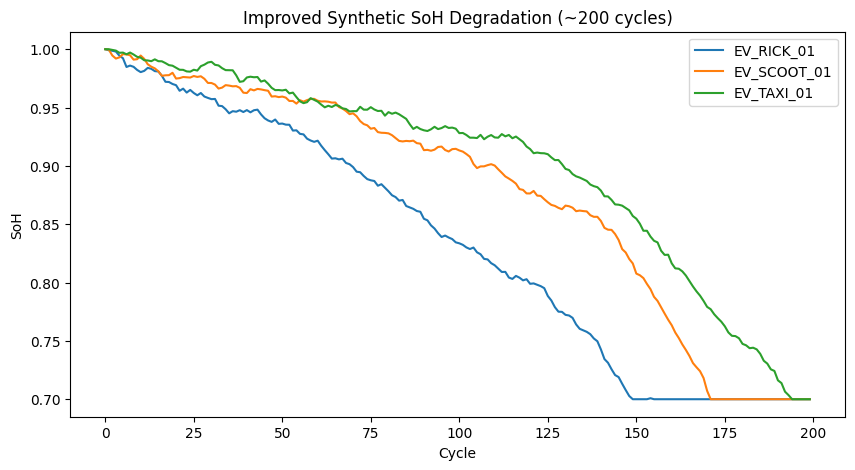

In [12]:
plt.figure(figsize=(10,5))

for dev in synthetic_df["device_id"].unique():
    soh_curve = synthetic_df[synthetic_df.device_id == dev] \
                .groupby("cycle_count")["soh"].first()
    plt.plot(soh_curve, label=dev)

plt.title("Improved Synthetic SoH Degradation (~200 cycles)")
plt.xlabel("Cycle")
plt.ylabel("SoH")
plt.legend()
plt.show()


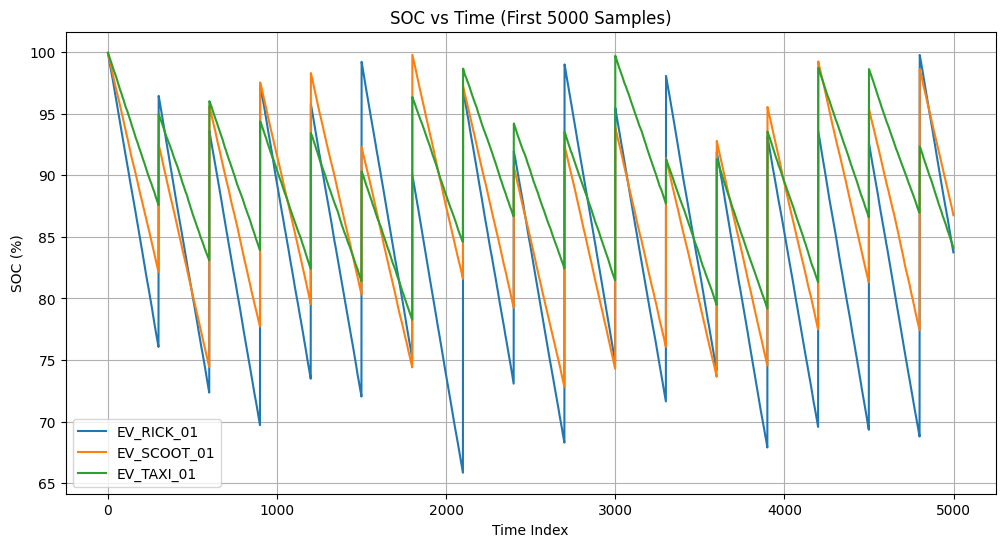

In [13]:
# SOC comparison
plt.figure(figsize=(12,6))

for dev in synthetic_df["device_id"].unique():
    sample = synthetic_df[synthetic_df["device_id"] == dev].head(5000)
    plt.plot(sample["soc"].values, label=dev)

plt.title("SOC vs Time (First 5000 Samples)")
plt.xlabel("Time Index")
plt.ylabel("SOC (%)")
plt.legend()
plt.grid(True)
plt.show()

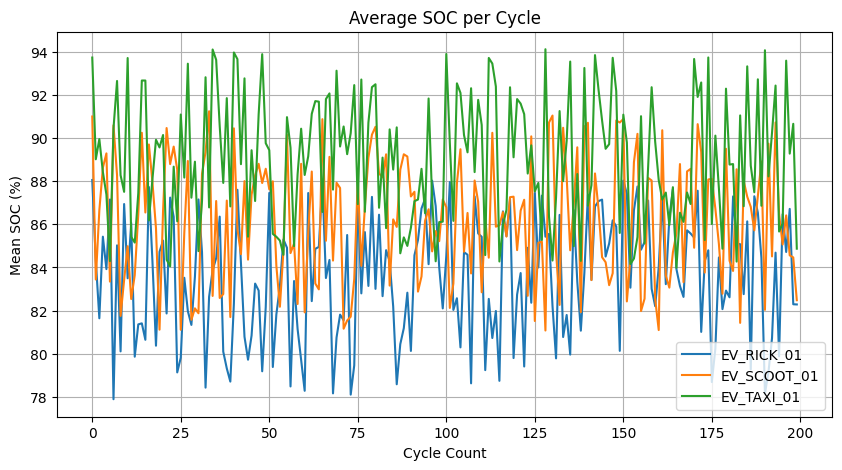

In [15]:
#SOC vs Cycle (Averaged Per Cycle)
plt.figure(figsize=(10,5))

for dev in synthetic_df["device_id"].unique():
    cycle_soc = synthetic_df[synthetic_df["device_id"] == dev] \
                .groupby("cycle_count")["soc"].mean()
    plt.plot(cycle_soc, label=dev)

plt.title("Average SOC per Cycle")
plt.xlabel("Cycle Count")
plt.ylabel("Mean SOC (%)")
plt.legend()
plt.grid(True)
plt.show()


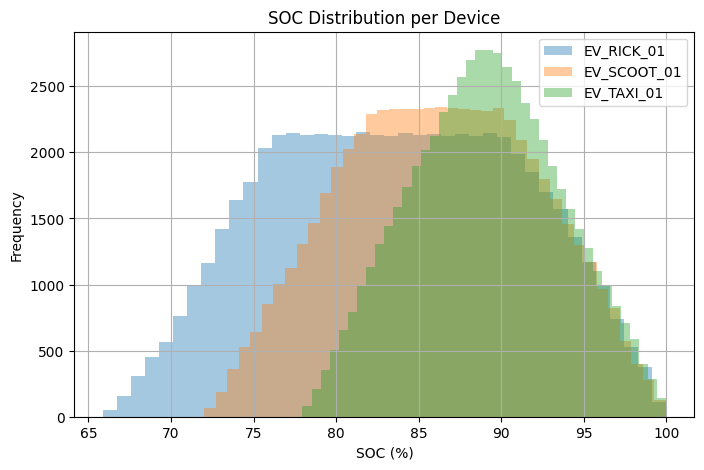

In [16]:
#SOC Distribution Histogram
plt.figure(figsize=(8,5))

for dev in synthetic_df["device_id"].unique():
    plt.hist(
        synthetic_df[synthetic_df["device_id"] == dev]["soc"],
        bins=40,
        alpha=0.4,
        label=dev
    )

plt.title("SOC Distribution per Device")
plt.xlabel("SOC (%)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


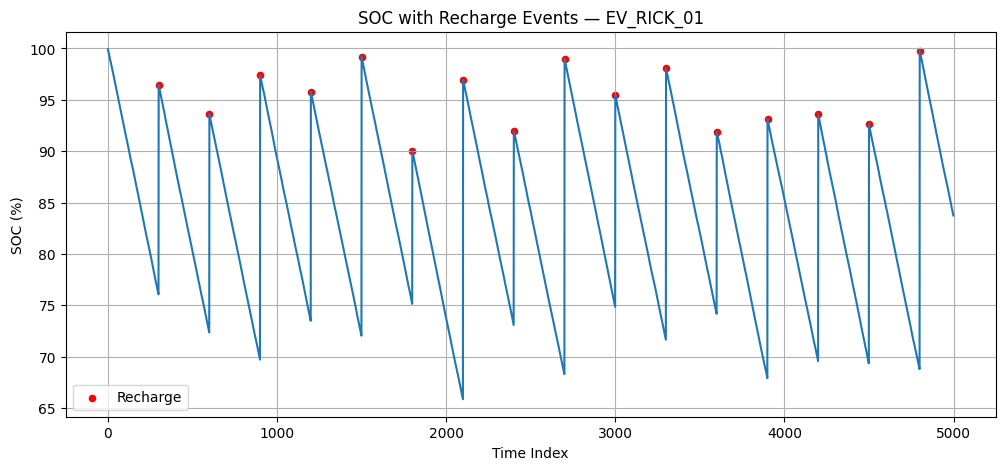

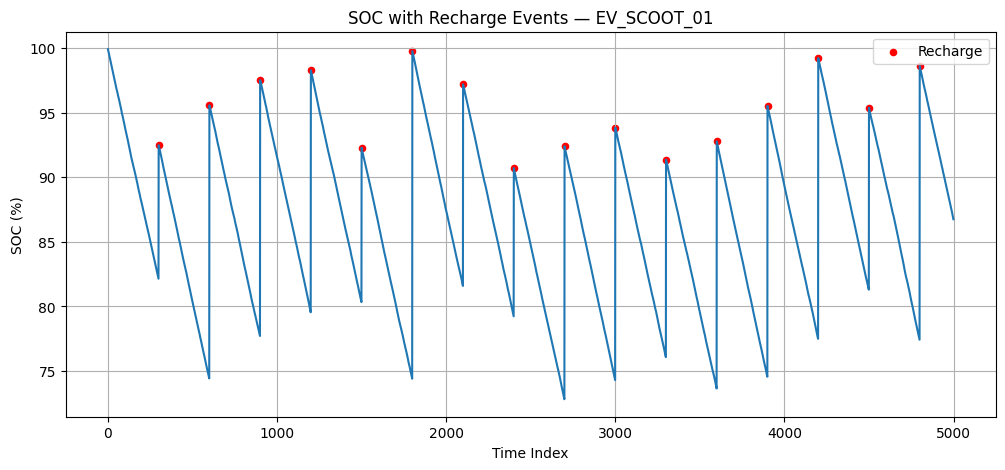

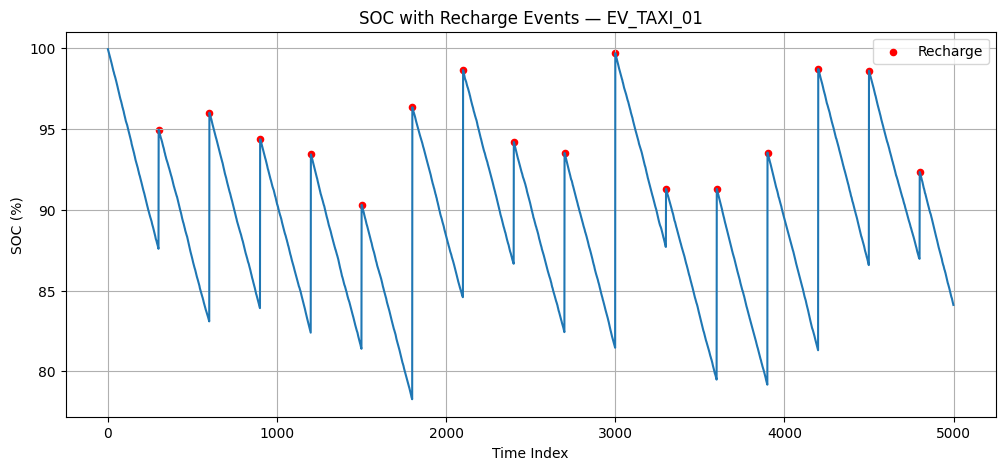

In [21]:
for dev in synthetic_df["device_id"].unique():

    sample = synthetic_df[synthetic_df["device_id"] == dev].head(5000).reset_index(drop=True)

    plt.figure(figsize=(12,5))

    plt.plot(sample["soc"].values)

    cycle_changes = sample["cycle_count"].diff().fillna(0) > 0
    recharge_indices = np.where(cycle_changes)[0]

    plt.scatter(
        recharge_indices,
        sample.loc[recharge_indices, "soc"],
        color="red",
        s=20,
        label="Recharge"
    )

    plt.title(f"SOC with Recharge Events — {dev}")
    plt.xlabel("Time Index")
    plt.ylabel("SOC (%)")
    plt.legend()
    plt.grid(True)


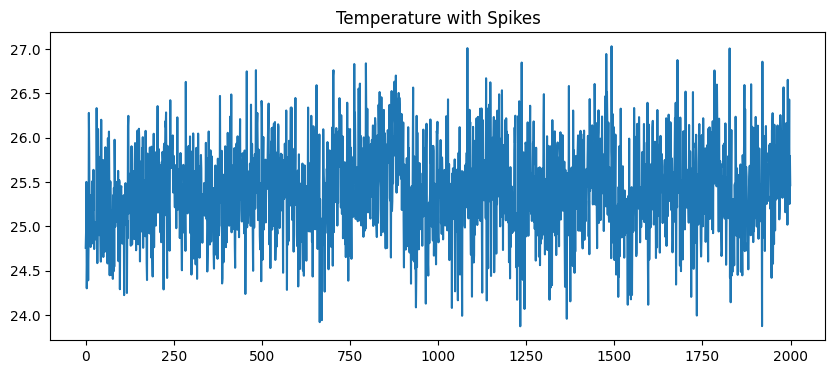

In [22]:
# Temperature
sample = synthetic_df[synthetic_df.device_id=="EV_RICK_01"].head(2000)

plt.figure(figsize=(10,4))
plt.plot(sample["temperature"])
plt.title("Temperature with Spikes")
plt.show()

In [23]:
#Event counts
synthetic_df["event"].value_counts()


,count
event,
normal,180000


Save Files

In [24]:
synthetic_df.to_csv("phase2_synthetic.csv", index=False)

synthetic_df.to_json(
    "phase2_synthetic.jsonl",
    orient="records",
    lines=True
)

print("Phase 2 synthetic files saved successfully")


Phase 2 synthetic files saved successfully


In [25]:

phase2_df = pd.read_csv("phase2_synthetic.csv", parse_dates=["timestamp"])

print("\nShape of dataset:", phase2_df.shape)
print("\nColumns:")
print(phase2_df.columns)

print("\nFirst 5 rows:")
print(phase2_df.head())

print("\nLast 5 rows:")
print(phase2_df.tail())

print("\nMax cycle count per device:")
print(phase2_df.groupby("device_id")["cycle_count"].max())



Shape of dataset: (180000, 10)

Columns:
Index(['device_id', 'timestamp', 'pack_voltage', 'current', 'temperature',
       'soc', 'cycle_count', 'soh', 'event', 'source'],
      dtype='object')

First 5 rows:
    device_id                  timestamp  pack_voltage  current  temperature  \
0  EV_RICK_01 2026-02-17 11:20:03.925193      4.169275     -0.8    24.759077   
1  EV_RICK_01 2026-02-17 11:20:04.925193      4.185665     -0.8    24.933922   
2  EV_RICK_01 2026-02-17 11:20:05.925193      4.224227     -0.8    25.501891   
3  EV_RICK_01 2026-02-17 11:20:06.925193      4.232390     -0.8    24.302518   
4  EV_RICK_01 2026-02-17 11:20:07.925193      4.236964     -0.8    24.631794   

         soc  cycle_count  soh   event     source  
0  99.920118            0  1.0  normal  synthetic  
1  99.846514            0  1.0  normal  synthetic  
2  99.771057            0  1.0  normal  synthetic  
3  99.679143            0  1.0  normal  synthetic  
4  99.606017            0  1.0  normal  synthetic

In [26]:
print("\nSoH statistics per device:")
print(phase2_df.groupby("device_id")["soh"].describe())



SoH statistics per device:
               count      mean       std  min       25%       50%       75%  \
device_id                                                                     
EV_RICK_01   60000.0  0.833391  0.104450  0.7  0.700652  0.834052  0.936099   
EV_SCOOT_01  60000.0  0.877764  0.098220  0.7  0.814213  0.912661  0.959074   
EV_TAXI_01   60000.0  0.900701  0.085684  0.7  0.856480  0.929056  0.964955   

             max  
device_id         
EV_RICK_01   1.0  
EV_SCOOT_01  1.0  
EV_TAXI_01   1.0  


In [27]:
print(synthetic_df.groupby("device_id")["soh"].min())


device_id
EV_RICK_01     0.7
EV_SCOOT_01    0.7
EV_TAXI_01     0.7
Name: soh, dtype: float64
